In [1]:
import sys
import os
# setting path
sys.path.append('/work/scripts')
import pandas as pd
import seaborn as sns
import output_utils as ou
import xarray as xr
from glob import glob
import numpy as np
from sklearn.metrics import r2_score

In [2]:
cell_y_coord = 0
cell_x_coord = 1

In [58]:
depthlist = [0.05, 0.1, 0.2, 0.3]

def get_lwclayer_tlayer(depthlist, run_dir, var):
    
    ### read the netcdf output files and compute year from the time dimension
    data = xr.open_dataset(f'{run_dir}/output/{var}_monthly_tr.nc')
    data = data.to_dataframe()
    data.reset_index(inplace=True)
    data.dtypes
    data['time'] = data['time'].astype('|S80')
    data['time'] = data['time'].astype('|datetime64[ns]')
    data['month'] = data['time'].dt.month
    data['year'] = data['time'].dt.year
    data = data.sort_values(['time','x','y','layer'])


    ### read the netcdf output files on soil structure and compute year from the time dimension
    dz = xr.open_dataset(f'{run_dir}/output/LAYERDZ_monthly_tr.nc')
    dz = dz.to_dataframe()
    dz.reset_index(inplace=True)
    dz.dtypes
    dz['time'] = dz['time'].astype('|S80')
    dz['time'] = dz['time'].astype('|datetime64[ns]')
    dz['month'] = dz['time'].dt.month
    dz['year'] = dz['time'].dt.year
    dz = dz.sort_values(['time','x','y','layer'])

    ### read the netcdf output files on soil structure and compute year from the time dimension
    lt = xr.open_dataset(f'{run_dir}/output/LAYERTYPE_monthly_tr.nc')
    lt = lt.to_dataframe()
    lt.reset_index(inplace=True)
    lt.dtypes
    lt['time'] = lt['time'].astype('|S80')
    lt['time'] = lt['time'].astype('|datetime64[ns]')
    lt['month'] = lt['time'].dt.month
    lt['year'] = lt['time'].dt.year
    lt = lt.sort_values(['time','x','y','layer'])
    dz=pd.merge(dz, lt[['LAYERTYPE', 'time', 'x', 'y', 'layer']], on=['time','x','y','layer'])


    ### compute the depth of the bottom of every layers
    dz['z'] = dz.groupby(['time','x','y'])['LAYERDZ'].cumsum(axis=0)
    
    ### loop through the list of depths of reference to compute the soil variable at that depth via linear interpolation
    stdz = []
    for i in range(len(depthlist)):
        dpth = depthlist[i]
        print("depth:", dpth,"m")
        # extract the top and bottom layers the closest to the depth of reference
        dz['diff'] = dz['z']-float(dpth)
        top = dz.loc[dz[(dz['diff'] <= 0)].groupby(['time','x','y'])['diff'].idxmax()]
        bot = dz.loc[dz[(dz['diff'] >= 0)].groupby(['time','x','y'])['diff'].idxmin()]
        # select the variable value for each of these top and bottom layers
        datatop = pd.merge(data, top[['year','month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month', 'x','y'])
        datatop = datatop[datatop['z'].notna()]
        datatop = datatop.rename(columns={"layer": "layertop", var: var+"top", "LAYERDZ": "dztop", "z": "ztop", "LAYERTYPE": "typetop"})
        databot = pd.merge(data, bot[['year', 'month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month' , 'x','y'])
        databot = databot[databot['z'].notna()]
        databot = databot.rename(columns={"layer": "layerbot", var: var+"bot", "LAYERDZ": "dzbot", "z": "zbot", "LAYERTYPE": "typebot"})
        # merge the data to do the linear interpolation
        datastdz = pd.merge(datatop, databot, how="outer", on=['time','year', 'month', 'x','y'])
        datastdz['a'] = (datastdz[var+"top"] - datastdz[var+"bot"]) / (datastdz['ztop'] - datastdz['zbot'])
        datastdz['b'] = datastdz[var+"top"] - (datastdz['a'] * datastdz['ztop'])
        datastdz[var] = (datastdz['a'] * float(dpth)) + datastdz['b']
        datastdz['z'] = float(dpth)
        datastdz['layer'] = i
        datastdz['type'] = datastdz['typebot']
        datastdz = datastdz[['time','x','y','layer','z','type',var]]
        stdz.append(datastdz)

    stdz = pd.concat(stdz)
    
    return stdz

In [59]:
stdz = get_lwclayer_tlayer(depthlist, '/data/workflows/US-Prr_SWC_SA/sample_000000003/', 'LWCLAYER')

depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m


In [60]:
out_dir ='/data/workflows/US-Prr_SWC_SA/'

In [61]:
run_dirs = [d for d in glob(out_dir+'*/', recursive = True) if 'sample' in d]

In [62]:
run_dirs

['/data/workflows/US-Prr_SWC_SA/sample_000000038/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000040/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000015/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000003/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000004/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000048/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000041/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000019/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000011/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000039/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000032/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000034/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000042/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000035/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000001/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000022/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000026/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000049/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000021/',
 '/data/work

In [63]:
lwc_layers = []
t_layers = []
sample_dfs=[]
for d in run_dirs:
    if 'GPP_monthly_tr.nc' in os.listdir(os.path.join(d, 'output')):
        sample = int(d.split('/')[-2].split('_')[-1])
        
        
        TLAYER = ou.load_trsc_dataframe(var ='TLAYER', timeres='monthly', px_y=0, px_x=1, fileprefix=f'{d}output/')[0]
        LAYERDEPTH = ou.load_trsc_dataframe(var ='LAYERDEPTH', timeres='monthly', px_y=0, px_x=1, fileprefix=f'{d}output/')[0]
        LAYERDZ = ou.load_trsc_dataframe(var ='LAYERDZ', timeres='monthly', px_y=0, px_x=1, fileprefix=f'{d}output/')[0]
        GPP = ou.load_trsc_dataframe(var ='GPP', timeres='monthly', px_y=0, px_x=1, fileprefix=f'{d}output/')[0][0]
        
        RH = ou.load_trsc_dataframe(var ='RH', timeres='monthly', px_y=0, px_x=1, fileprefix=f'{d}output/')[0][0]

        sample_df = pd.DataFrame({'date': GPP.index, 'sample': [sample]*len(GPP), #'LWCLAYER': LWCLAYER, 'TLAYER': TLAYER, 'LAYERDEPTH': LAYERDEPTH, 'LAYERDZ': LAYERDZ,
                                  'GPP': GPP, 'RH':RH})
        sample_dfs.append(sample_df)
        
        LWCLAYER = get_lwclayer_tlayer(depthlist, d, 'LWCLAYER')
        LWCLAYER['sample'] = sample
        lwc_layers.append(LWCLAYER)
        
        TLAYER = get_lwclayer_tlayer(depthlist, d, 'TLAYER')
        TLAYER['sample'] = sample
        t_layers.append(TLAYER)
        
sample_dfs=pd.concat(sample_dfs)
lwc_layers=pd.concat(lwc_layers)
t_layers=pd.concat(t_layers)

Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/ou

depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000022/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000022/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000022/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000022/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000022/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000026/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000026/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000026/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sa

depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000033/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000033/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000033/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000033/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000033/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000044/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000044/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000044/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sa

depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000016/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000016/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000016/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000016/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000016/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000007/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000007/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000007/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sa

In [64]:
path_to_met_data = '/data/comparison_data/US-Prr-monthly.csv'

In [65]:
met_data = pd.read_csv(path_to_met_data)
met_data['m_y'] = pd.to_datetime(met_data['m_y'])
met_data['year'] = met_data['m_y'].dt.year
met_data = met_data.replace(-9999.0, np.nan)
met_data['SWC_1_1_1'] = met_data['SWC_1_1_1']/100
met_data['SWC_1_2_1'] = met_data['SWC_1_2_1']/100
met_data['SWC_1_3_1'] = met_data['SWC_1_3_1']/100
met_data['SWC_1_4_1'] = met_data['SWC_1_4_1']/100
met_data.head()


,Unnamed: 0,Year_x,Month_x,GPP1 (gC/m2/d),RECO1 (gC/m2/d),NEE1 (gC/m2/d),GPP2 (gC/m2/d),RECO2 (gC/m2/d),NEE2 (gC/m2/d),P_RAIN,...,SWC_1_3_1,SWC_1_4_1,SWC_1_5_1,TS_1_1_1,TS_1_2_1,TS_1_3_1,TS_1_4_1,TS_1_5_1,TS_1_6_1,year
0,0,2010,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
1,1,2010,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
2,2,2010,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
3,3,2010,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
4,4,2010,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010


In [66]:
sample_dfs = sample_dfs.reset_index(drop=True)

<AxesSubplot:xlabel='date', ylabel='GPP'>

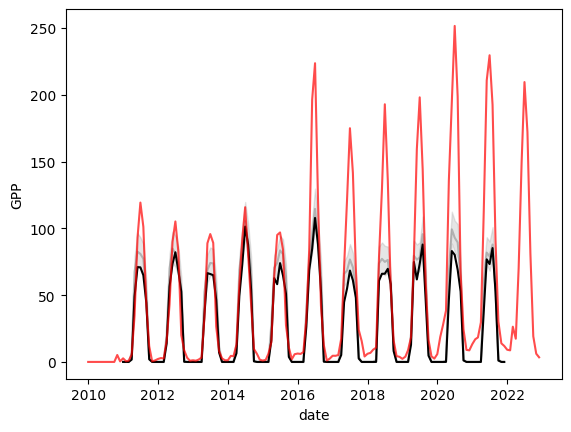

In [67]:
sns.lineplot(data=sample_dfs[sample_dfs['date'].dt.year>2010], x='date', y='GPP', color='grey', legend=False, alpha=0.5)
sns.lineplot(data=sample_dfs[(sample_dfs['date'].dt.year>2010) & (sample_dfs['sample']==15)], x='date', y='GPP', color='black', legend=False)
sns.lineplot(data=met_data, x='m_y', y='GPP1 (gC/m2/d)', color='red', alpha=0.7)#
#sns.scatterplot(data=met_data, x='m_y', y='GPP2 (gC/m2/d)', color='blue', alpha=0.7, s=10)

In [69]:
t_layers=t_layers.reset_index(drop=True)
lwc_layers=lwc_layers.reset_index(drop=True)

In [70]:
tlayer_merged = t_layers[['time', 'z', 'TLAYER', 'sample']].merge(met_data[['m_y', 'TS_1_2_1', 'TS_1_3_1']], left_on = ['time'], right_on=['m_y'], how='left')
tlayer_merged= tlayer_merged.loc[~tlayer_merged['TS_1_2_1'].isna() & ~tlayer_merged['TS_1_3_1'].isna() & ~tlayer_merged['TLAYER'].isna()]

In [71]:
lwclayer_merged = lwc_layers[['time', 'z', 'LWCLAYER', 'sample']].merge(met_data[['m_y', 'SWC_1_2_1', 'SWC_1_3_1']], left_on = ['time'], right_on=['m_y'], how='left')
lwclayer_merged= lwclayer_merged.loc[~lwclayer_merged['SWC_1_2_1'].isna() & ~lwclayer_merged['SWC_1_3_1'].isna() & ~lwclayer_merged['LWCLAYER'].isna()]

In [72]:
r2s_10cm = []
r2s_20cm = []
samples = []
for sample in tlayer_merged['sample'].unique():
    tlayer_sample = tlayer_merged.loc[tlayer_merged['sample']==sample]
    if len(tlayer_sample.loc[tlayer_sample['z']==0.1])>0:
        r2_10cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.1, 'TS_1_2_1'], tlayer_sample.loc[tlayer_sample['z']==0.1, 'TLAYER'])
        r2_20cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.2, 'TS_1_3_1'], tlayer_sample.loc[tlayer_sample['z']==0.2, 'TLAYER'])

        samples.append(sample)
        r2s_10cm.append(r2_10cm)
        r2s_20cm.append(r2_20cm)
    
df_tlayer = pd.DataFrame({'sample': samples, 'r2_10cm': r2s_10cm, 'r2_20cm': r2s_20cm})

In [73]:
df_tlayer.sort_values(by='r2_20cm')

,sample,r2_10cm,r2_20cm
37,5,-14.218283,-17.341339
15,22,-9.524025,-10.729253
20,20,-7.551645,-9.525270
47,37,-9.964283,-8.348276
25,13,-7.283993,-8.292089
19,0,-5.990263,-6.754949
31,36,-7.244675,-5.818596
10,32,-6.710550,-5.646557
22,2,-5.028693,-4.734802
7,19,-2.124194,-4.605097


<AxesSubplot:xlabel='time', ylabel='TLAYER'>

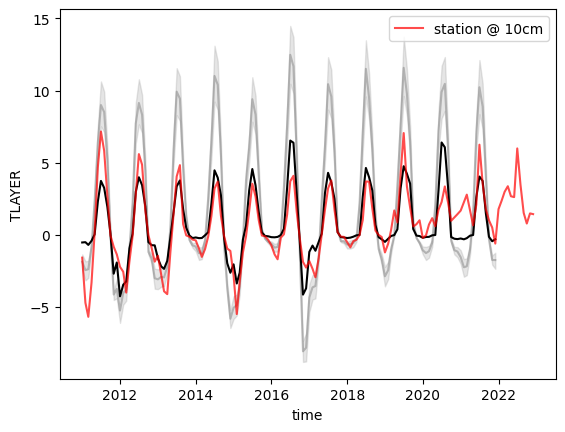

In [74]:
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.1) & (t_layers['time'].dt.year>2010)], x='time', y='TLAYER', color = 'grey', alpha=0.5)
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.1) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==4)], x='time', y='TLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='TS_1_2_1', color='red', alpha = 0.7, label='station @ 10cm') #-0.1 m

<AxesSubplot:xlabel='time', ylabel='TLAYER'>

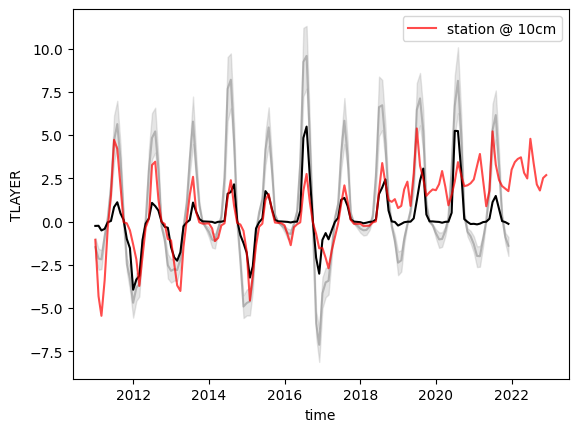

In [75]:
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.2) & (t_layers['time'].dt.year>2010)], x='time', y='TLAYER', color = 'grey', alpha=0.5)
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.2) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==4)], x='time', y='TLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='TS_1_3_1', color='red', alpha = 0.7, label='station @ 10cm') #-0.1 m

In [43]:
lwclayer_merged

,time,z,LWCLAYER,sample,m_y,SWC_1_2_1,SWC_1_3_1
2776,2011-05-01,0.1,0.116136,38,2011-05-01,0.390908,0.186683
2777,2011-06-01,0.1,0.372944,38,2011-06-01,0.814515,0.708910
2778,2011-07-01,0.1,0.406952,38,2011-07-01,0.809233,0.836910
2779,2011-08-01,0.1,0.408733,38,2011-08-01,0.831707,0.836910
2780,2011-09-01,0.1,0.345477,38,2011-09-01,0.836910,0.836910
...,...,...,...,...,...,...,...
209082,2021-07-01,0.2,0.351876,23,2021-07-01,0.655261,0.755904
209083,2021-08-01,0.2,0.705937,23,2021-08-01,0.751810,0.835364
209084,2021-09-01,0.2,0.715967,23,2021-09-01,0.839350,0.838763
209086,2021-11-01,0.2,0.063119,23,2021-11-01,0.561844,0.715605


In [44]:
lwclayer_r2s_10cm = []
lwclayer_r2s_20cm = []
samples = []
for sample in tlayer_merged['sample'].unique():
    print(sample)
    lwclayer_sample = lwclayer_merged.loc[lwc_layers['sample']==sample]
    if len(lwclayer_sample.loc[lwclayer_sample['z']==0.1])>0:
        r2_10cm = r2_score(lwclayer_sample.loc[lwclayer_sample['z']==0.1, 'SWC_1_2_1'], lwclayer_sample.loc[lwclayer_sample['z']==0.1, 'LWCLAYER'])
        r2_20cm = r2_score(lwclayer_sample.loc[lwclayer_sample['z']==0.2, 'SWC_1_3_1'], lwclayer_sample.loc[lwclayer_sample['z']==0.2, 'LWCLAYER'])

        samples.append(sample)
        lwclayer_r2s_10cm.append(r2_10cm)
        lwclayer_r2s_20cm.append(r2_20cm)
    
df_lwclayer = pd.DataFrame({'sample': samples, 'r2_10cm': lwclayer_r2s_10cm, 'r2_20cm': lwclayer_r2s_20cm})

38
40
15
3
4
48
41
19
11
39
32
34
42
35
1
22
26
49
21
0
20
18
2
45
6
13
17
9
27
33
44
36
43
12
29
24
5
8
25
10
31
30
28
16
7
14
37
23


In [46]:
df_lwclayer.sort_values(by='r2_20cm')

,sample,r2_10cm,r2_20cm
18,21,-2.388322,-2.730285
24,6,-2.226291,-2.708061
6,41,-1.996021,-2.563248
3,3,-2.016549,-2.394724
7,19,-0.410994,-0.894173
41,30,-0.416540,-0.773736
42,28,-0.753559,-0.711557
36,5,0.060404,-0.680325
34,29,-0.603845,-0.667773
47,23,-0.178729,-0.587719


<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

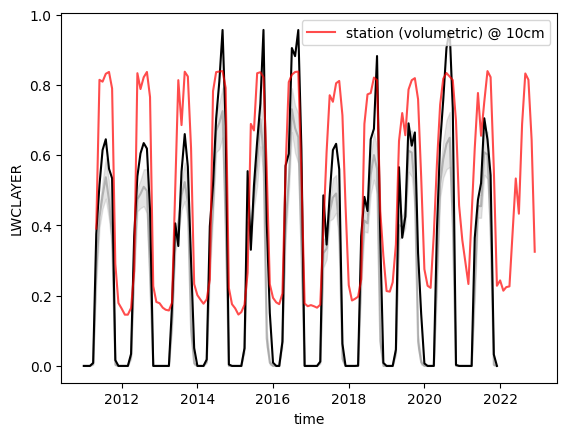

In [56]:
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.1) & (lwc_layers['time'].dt.year>2010)], x='time', y='LWCLAYER', color = 'grey', alpha = 0.5)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.1) & (lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==0)], x='time', y='LWCLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='SWC_1_2_1', color = 'red', alpha = 0.7, label='station (volumetric) @ 10cm') #-0.1 m


<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

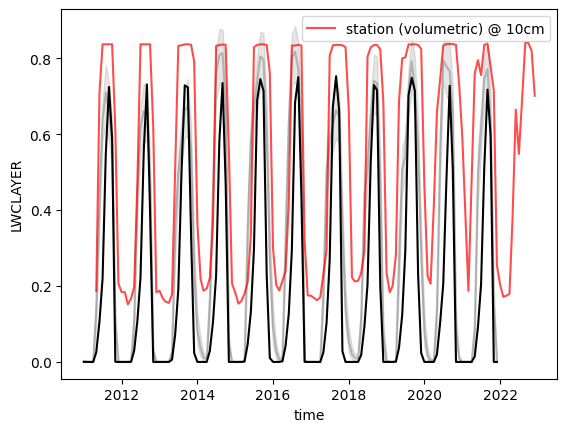

In [48]:
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.2) & (lwc_layers['time'].dt.year>2010)], x='time', y='LWCLAYER', color = 'grey', alpha = 0.5)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.2) & (lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==19)], x='time', y='LWCLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='SWC_1_3_1', color = 'red', alpha = 0.7, label='station (volumetric) @ 10cm') #-0.1 m
